In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(20)

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101/Caltech101'
batch_size = 64
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size//8, shuffle=True, num_workers=4) for x in ['eval', 'test']}
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', '

In [5]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        
        self.conv1_112=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5,stride=1, padding=(2,2)),             
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2_56=nn.Sequential(
            nn.Conv2d(32,64,5,1,2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3_28=nn.Sequential(
            nn.Conv2d(64,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )   
        self.conv4_14=nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5_7=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6_7=nn.Sequential(
            nn.Conv2d(256,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.FC=nn.Sequential(
            nn.Linear(6272,1568),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1568,392),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(392,101) 
        )
        
    def forward(self,x):
        x = self.conv1_112(x)
        x = self.conv2_56(x)
        x = self.conv3_28(x)
        x = self.conv4_14(x)
        x = self.conv5_7(x)
        x = self.conv6_7(x)
        x = x.view(x.size(0),-1)
        x = self.FC(x)

        return x

In [6]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs):
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
#     lrs = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            step_loss = []
            step_acc = []
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                # forward，track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
#                         lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
#                     if phase == 'eval':
# #                         scheduler.step(loss) # ReduceLROnPlateau
#                         scheduler.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                step_loss.append(loss.item())
                step_acc.append(float(torch.sum(preds == labels.data)) / preds.size(0))                     
                
                # statistics                
                if step%30==1:
                    statistics[phase][0].append(np.mean(step_loss))
                    statistics[phase][1].append(np.mean(step_acc))
                    step_loss = []
                    step_acc = []

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
#         scheduler.step()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

#     model.load_state_dict(torch.load('checkpoint.pt'))
    return model, statistics

In [7]:
model2 = Net2()
model2 = model2.to(device)
num_epochs = 100

criterion1 = nn.CrossEntropyLoss()
# optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optimizer1 = optim.Adam(model2.parameters(),lr=0.001,weight_decay=1e-5)
# step_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=30, gamma=0.5) # Decay LR by a factor of 0.1 every 30 epochs
# num_steps = 95 * num_epochs
# cosine_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer1, T_max = num_steps) 

In [8]:
# model2, statistics, lrs = train_model(model2, criterion1, optimizer1, cosine_lr_scheduler, num_epochs=num_epochs)
model2, statistics = train_model(model2, criterion1, optimizer1, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 4.3189 Acc: 0.1001
eval Loss: 3.8934 Acc: 0.1268

Epoch 1/99
----------
train Loss: 4.0220 Acc: 0.1680
eval Loss: 3.6711 Acc: 0.2232

Epoch 2/99
----------
train Loss: 3.8647 Acc: 0.2100
eval Loss: 3.3832 Acc: 0.2549

Epoch 3/99
----------
train Loss: 3.6758 Acc: 0.2254
eval Loss: 3.2871 Acc: 0.2610

Epoch 4/99
----------
train Loss: 3.6071 Acc: 0.2278
eval Loss: 3.2542 Acc: 0.2805

Epoch 5/99
----------
train Loss: 3.5037 Acc: 0.2515
eval Loss: 3.0613 Acc: 0.3012

Epoch 6/99
----------
train Loss: 3.4031 Acc: 0.2694
eval Loss: 2.9854 Acc: 0.3232

Epoch 7/99
----------
train Loss: 3.3785 Acc: 0.2657
eval Loss: 2.9577 Acc: 0.3329

Epoch 8/99
----------
train Loss: 3.3360 Acc: 0.2709
eval Loss: 2.9180 Acc: 0.3451

Epoch 9/99
----------
train Loss: 3.3011 Acc: 0.2861
eval Loss: 2.9947 Acc: 0.3488

Epoch 10/99
----------
train Loss: 3.2528 Acc: 0.2863
eval Loss: 2.8213 Acc: 0.3768

Epoch 11/99
----------
train Loss: 3.1926 Acc: 0.2898
eval Loss: 2.7424 Acc

In [9]:
# lr = np.array(lrs)[:,1]
# plt.plot(np.arange(len(lr)),lr)

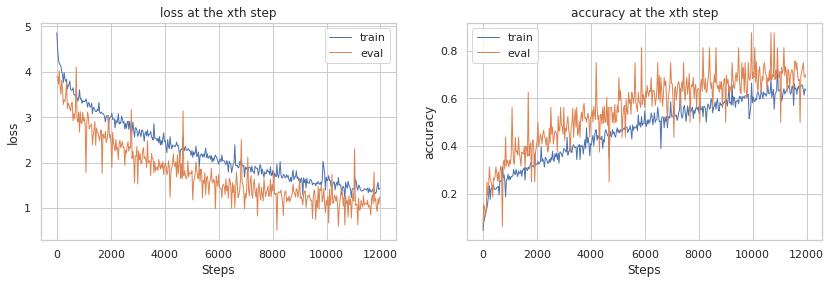

In [10]:
num_epochs=100
def visualize_accuracy(num_epochs, statistics):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist))*30, loss_hist, label = phase, linewidth = 1)
#         ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.set(xlabel = 'Steps', ylabel='loss',title='loss at the xth step');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist))*30, acc_hist, label = phase, linewidth = 1)
#         ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.set(xlabel = 'Steps', ylabel='accuracy',title='accuracy at the xth step');
        ax2.legend();
        fig.savefig('acc_loss_model2.png')
visualize_accuracy(num_epochs, statistics)

In [11]:
PATH = '/kaggle/working/model2.pth'
torch.save(model2.state_dict(), PATH)